In [105]:
from qiskit import *
from qiskit.tools.visualization import array_to_latex , plot_histogram, plot_bloch_multivector
from math import pi
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.tools.monitor import job_monitor
from qiskit.extensions import Initialize
%matplotlib inline

IBMQ.save_account('bc198117720621ce2cefda12b1cf37946028d7cc2c6268b849ccebfc45a5495107087dc658b5b5b126029c6376b395d2ab21610dd03478183c4b0ce60f0d182f')


configrc.store_credentials:WARNING:2023-12-07 11:26:24,701: Credentials already present. Set overwrite=True to overwrite.


In [2]:
# Creating class and methods for both quantum simulators and real Quantum computers

class Simulators():

    def StateVectorSimulator(circuit):
        simulator = Aer.get_backend('statevector_simulator')
        statevector = execute(circuit, backend=simulator).result().get_statevector()
        return statevector

    def QasmSimulator(circuit, shots):
        simulator = Aer.get_backend('qasm_simulator')
        counts = execute(circuit, backend=simulator, shots=shots).result().get_counts()
        return counts

    def UnitarySimulator(circuit):
        simulator = Aer.get_backend('unitary_simulator')
        unitary = execute(circuit, backend=simulator).result().get_unitary()
        return unitary
    
class QuantumComputer():
    def __init__(self, name, circuit, shots):
        self.Quantum = name
        self.circuit = circuit
        self.shots = shots
        
    def RealQuantumComputer(self):
        provider = IBMQ.load_account()
        q_computer = provider.get_backend(self.Quantum)
        transpiled_circuit = transpile(self.circuit, q_computer)
        job = execute(transpiled_circuit, backend = q_computer, shots = self.shots)
        print(job.job_id())
        job_monitor(job)
        return job_monitor , job
    

In [3]:

# creating a shors circuit using 3 qubits and 2 classical bits

def shors_code(qubits,classicical_bits):
    circuit= QuantumCircuit(qubits,classicical_bits)
    
    circuit.cx(0,1) # Encoding the qubits
    circuit.cx(0,2)
    circuit.h(0)
    
    circuit.h(1) # appliying a hadamard gate to ancillary qubits for syndrome measurement
    circuit.h(2)
    
    circuit.measure([1,2], [0,1]) # measuring the ancillary qubits to two classical bis
    
    return circuit
    
shors= shors_code(3,2)

print(shors)

               ┌───┐      
q_0: ──■────■──┤ H ├──────
     ┌─┴─┐  │  ├───┤┌─┐   
q_1: ┤ X ├──┼──┤ H ├┤M├───
     └───┘┌─┴─┐├───┤└╥┘┌─┐
q_2: ─────┤ X ├┤ H ├─╫─┤M├
          └───┘└───┘ ║ └╥┘
c: 2/════════════════╩══╩═
                     0  1 


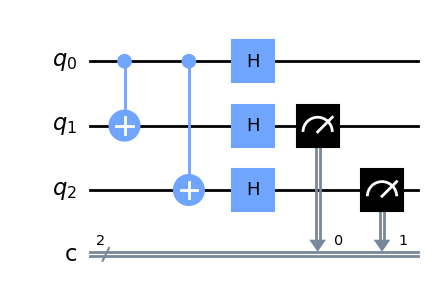

In [4]:
shors.draw(output='mpl') 

In [5]:
# function for the error corrections using a bit flip like repetition code

def error_correction(circuit, syndrom_result):
    for bit, position in enumerate(syndrom_result):
        if position == '1':
            circuit.x(bit)

In [6]:
# correcting the errors based on the syndrome results

def corrected_circuit(circuit,syndromes):
    for results in syndromes:
        corrected_circuit = circuit.copy()
        error_correction(corrected_circuit,results)
        print(f'corrected circuits for {results}')
        print(corrected_circuit)

Syndrome measurements:  {'01': 264, '11': 279, '00': 239, '10': 242}


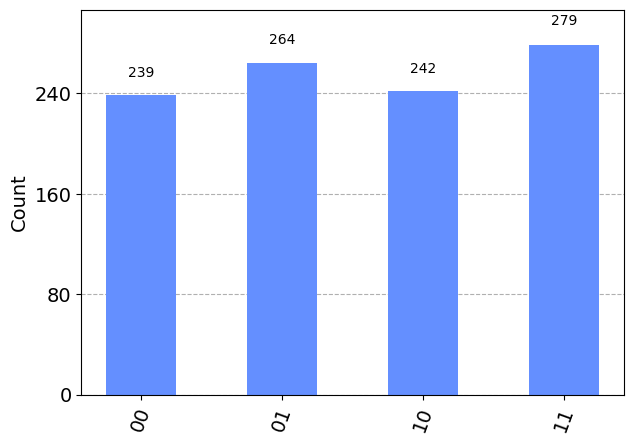

In [7]:
# error detection part using syndrome measurement on simulator

syndromes = Simulators.QasmSimulator(shors, 1024)

print('Syndrome measurements: ', syndromes)
plot_histogram(syndromes)

In [8]:
corrected_circuit(shors, syndromes) # corrected circuits according to the error occured

corrected circuits for 01
               ┌───┐        
q_0: ──■────■──┤ H ├────────
     ┌─┴─┐  │  ├───┤┌─┐┌───┐
q_1: ┤ X ├──┼──┤ H ├┤M├┤ X ├
     └───┘┌─┴─┐├───┤└╥┘└┬─┬┘
q_2: ─────┤ X ├┤ H ├─╫──┤M├─
          └───┘└───┘ ║  └╥┘ 
c: 2/════════════════╩═══╩══
                     0   1  
corrected circuits for 11
               ┌───┐┌───┐     
q_0: ──■────■──┤ H ├┤ X ├─────
     ┌─┴─┐  │  ├───┤└┬─┬┘┌───┐
q_1: ┤ X ├──┼──┤ H ├─┤M├─┤ X ├
     └───┘┌─┴─┐├───┤ └╥┘ └┬─┬┘
q_2: ─────┤ X ├┤ H ├──╫───┤M├─
          └───┘└───┘  ║   └╥┘ 
c: 2/═════════════════╩════╩══
                      0    1  
corrected circuits for 00
               ┌───┐      
q_0: ──■────■──┤ H ├──────
     ┌─┴─┐  │  ├───┤┌─┐   
q_1: ┤ X ├──┼──┤ H ├┤M├───
     └───┘┌─┴─┐├───┤└╥┘┌─┐
q_2: ─────┤ X ├┤ H ├─╫─┤M├
          └───┘└───┘ ║ └╥┘
c: 2/════════════════╩══╩═
                     0  1 
corrected circuits for 10
               ┌───┐┌───┐   
q_0: ──■────■──┤ H ├┤ X ├───
     ┌─┴─┐  │  ├───┤└┬─┬┘   
q_1: ┤ X ├──┼──┤ H ├─┤M├──

## Running on a real quantum computer

In [9]:
quantum = QuantumComputer('ibm_osaka', shors, 1024)

In [10]:
quantum_job_monitor, quantum_job = quantum.RealQuantumComputer()

cnrn43rgsbh0008sy2f0
Job Status: job has successfully run


In [11]:
quantum_results = quantum_job.result()

In [12]:
quantum_syndromes = quantum_results.get_counts(shors)

quantum computer syndrome measurements:  {'11': 250, '10': 277, '00': 263, '01': 234}


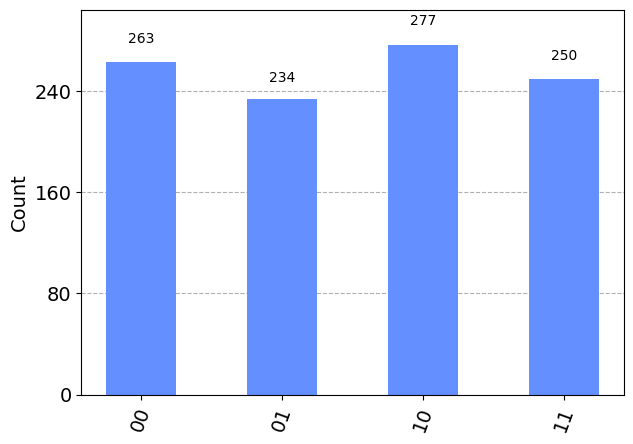

In [13]:
print('quantum computer syndrome measurements: ',quantum_syndromes)
plot_histogram(quantum_syndromes)

In [14]:
corrected_quantum_circuits = corrected_circuit(shors, quantum_syndromes)

corrected circuits for 11
               ┌───┐┌───┐     
q_0: ──■────■──┤ H ├┤ X ├─────
     ┌─┴─┐  │  ├───┤└┬─┬┘┌───┐
q_1: ┤ X ├──┼──┤ H ├─┤M├─┤ X ├
     └───┘┌─┴─┐├───┤ └╥┘ └┬─┬┘
q_2: ─────┤ X ├┤ H ├──╫───┤M├─
          └───┘└───┘  ║   └╥┘ 
c: 2/═════════════════╩════╩══
                      0    1  
corrected circuits for 10
               ┌───┐┌───┐   
q_0: ──■────■──┤ H ├┤ X ├───
     ┌─┴─┐  │  ├───┤└┬─┬┘   
q_1: ┤ X ├──┼──┤ H ├─┤M├────
     └───┘┌─┴─┐├───┤ └╥┘ ┌─┐
q_2: ─────┤ X ├┤ H ├──╫──┤M├
          └───┘└───┘  ║  └╥┘
c: 2/═════════════════╩═══╩═
                      0   1 
corrected circuits for 00
               ┌───┐      
q_0: ──■────■──┤ H ├──────
     ┌─┴─┐  │  ├───┤┌─┐   
q_1: ┤ X ├──┼──┤ H ├┤M├───
     └───┘┌─┴─┐├───┤└╥┘┌─┐
q_2: ─────┤ X ├┤ H ├─╫─┤M├
          └───┘└───┘ ║ └╥┘
c: 2/════════════════╩══╩═
                     0  1 
corrected circuits for 01
               ┌───┐        
q_0: ──■────■──┤ H ├────────
     ┌─┴─┐  │  ├───┤┌─┐┌───┐
q_1: ┤ X ├──┼──┤ H ├┤M├┤ X

## 9 Qubit

Testing the shors 9 qubit code in a real hardware

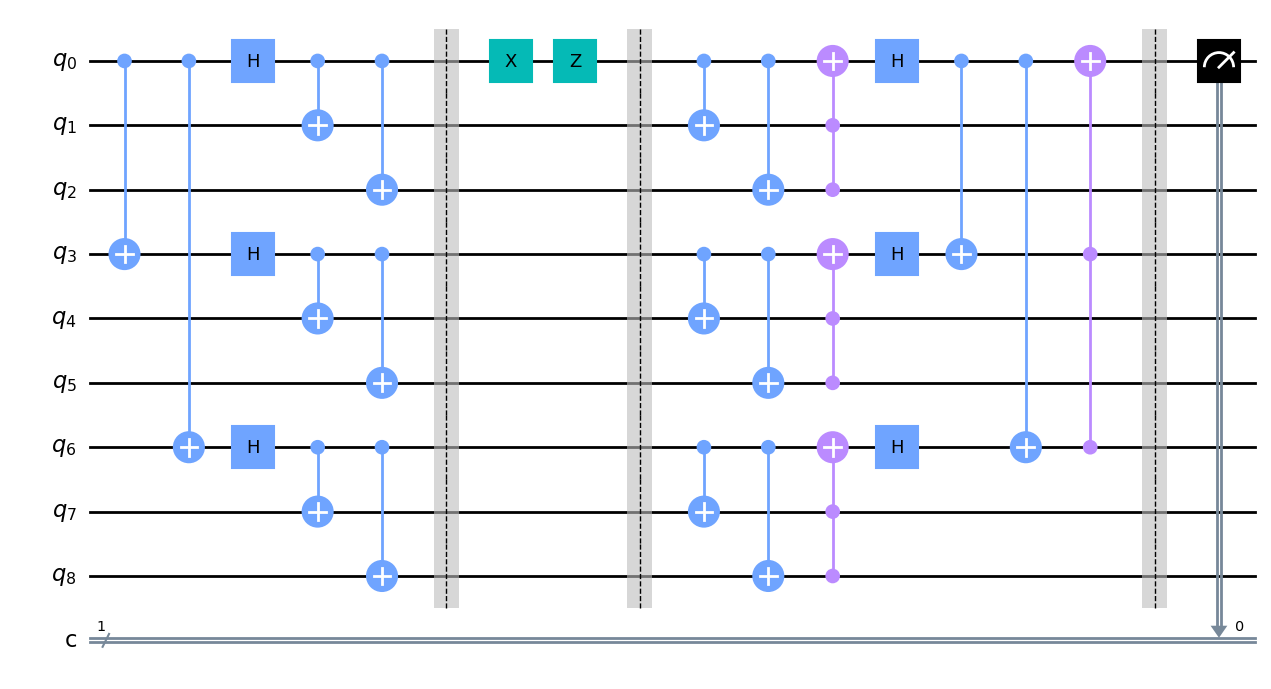

In [106]:
## Shors Algorithm

circuit = QuantumCircuit(9,1)

#Entangle qubits 0, 3, and 6.

circuit.cx(0,3)  
circuit.cx(0,6)

#Apply Hadamard gates on qubits 0, 3, and 6.
circuit.h([0,3,6])
circuit.cx([0,0,3,3,6,6],[1,2,4,5,7,8])
circuit.barrier()
circuit.x(0) # creating a bit flip on first qubit
circuit.z(0) # creating a phase flip on the first qubit
circuit.barrier()

# Apply CNOT gates to spread the errors to the corresponding qubits.

circuit.cx([0,0,3,3,6,6],[1,2,4,5,7,8])
# Apply Toffoli gates for error correction.
circuit.ccx(2,1,0)
circuit.ccx(5,4,3)
circuit.ccx(8,7,6)

# Apply Hadamard gates again.

circuit.h([0,3,6])


# Perform additional CNOT and Toffoli operations for error correction.
circuit.cx(0,3)
circuit.cx(0,6)
circuit.ccx(6,3,0)
circuit.barrier()

# Measure qubit 0 for error detection.

circuit.measure(0,0)
circuit.draw(output='mpl')

In [107]:
quantum_9_qubit = QuantumComputer('ibm_osaka', circuit2, 1024)

In [108]:
quantum_9_job_monitor , quantum_9_job = quantum_9_qubit.RealQuantumComputer()


ibmqfactory.load_account:WARNING:2023-12-07 11:28:21,348: Credentials are already in use. The existing account in the session will be replaced.


cnrtrr351cpg008ebsp0
Job Status: job has successfully run


In [109]:
# The outcome is completely different from that of the simulator

job_9_result = quantum_9_job.result()
print(job_9_counts)

{'1': 515, '0': 509}


 Creating a Quantum circuit to simulate the shors code 

In [36]:

ini_gate = Initialize([1,0])


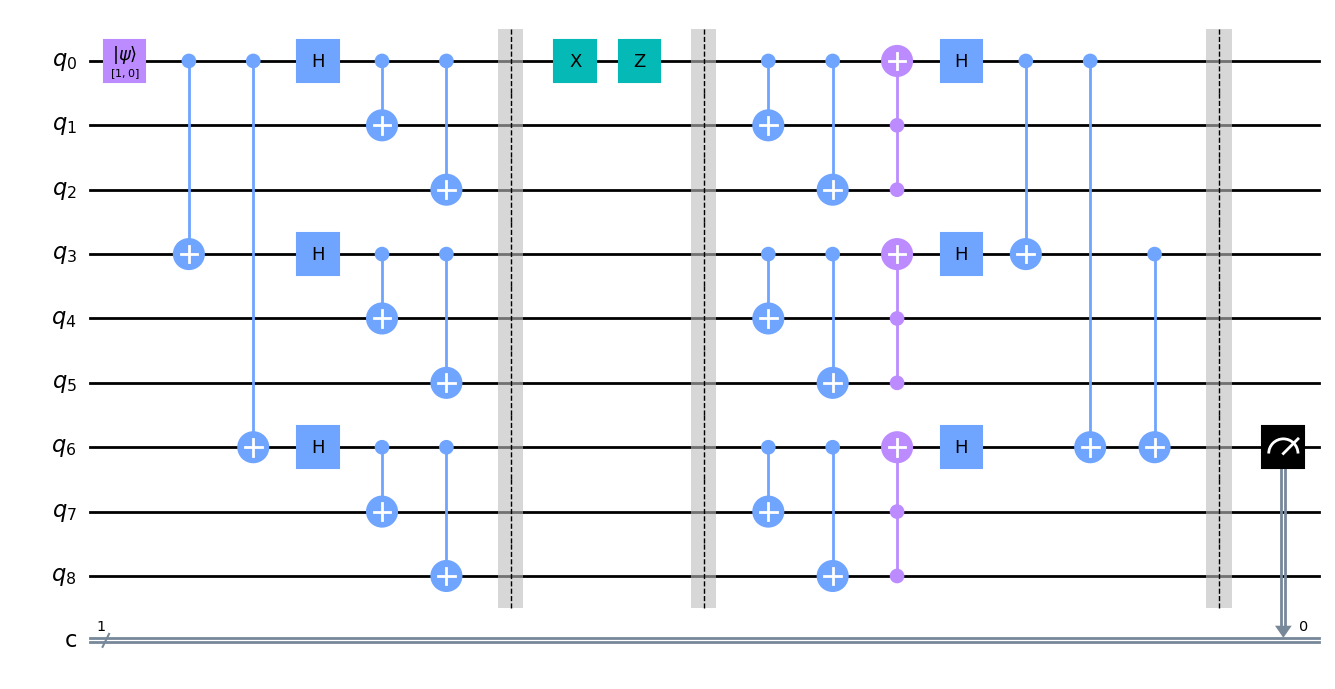

In [67]:
circuit = QuantumCircuit(9,1)
circuit.append(ini_gate,[0])
circuit.cx(0,3)
circuit.cx(0,6)
circuit.h([0,3,6])
circuit.cx(0,1)
circuit.cx(0,2)
circuit.cx(3,4)
circuit.cx(3,5)
circuit.cx(6,7)
circuit.cx(6,8)
circuit.barrier()

# creatng a bit and phase flip error

circuit.x(0)
circuit.z(0)


circuit.barrier()
circuit.cx(0,1)
circuit.cx(0,2)
circuit.cx(3,4)
circuit.cx(3,5)
circuit.cx(6,7)
circuit.cx(6,8)
circuit.ccx(1,2,0)
circuit.ccx(4,5,3)
circuit.ccx(8,7,6)
circuit.h([0,3,6])
circuit.cx(0,3)
circuit.cx(0,6)
# applying a controlled x gate on qubit 6 from 3 
# this will create a state of |00 0> and /11 0> just like repetition code
circuit.cx(3,6) 
circuit.barrier()
circuit.measure([6],[0]) # measuring the 6th qubit to check the outcome
circuit.draw(output='mpl')


In [68]:


shors_9_syndrome_counts = Simulators.QasmSimulator(circuit, 1024)
# as expected for the state /11> the outcome was 0 
print(shors_9_syndrome_counts)

{'0': 1024}


In [69]:
most_frequent = shors_9_syndrome_counts.most_frequent() # taking the most frequent occurance that is 0
most_frequent = [(most_frequent)]
print(most_frequent) 

['0']


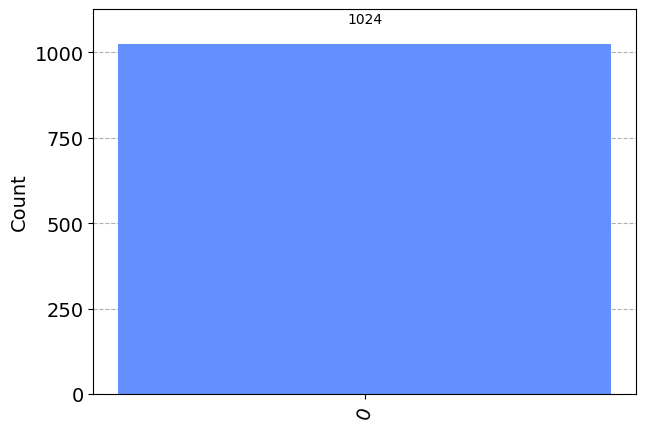

In [70]:
plot_histogram(shors_9_syndrome_counts)

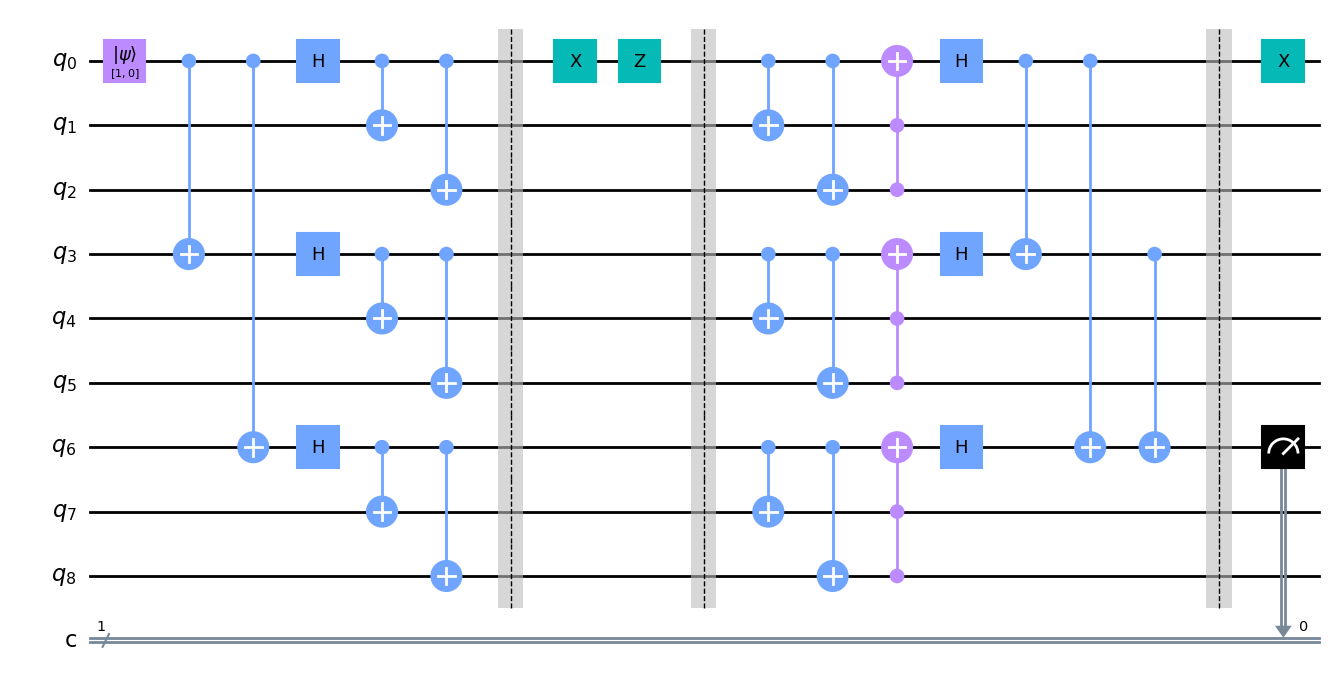

In [71]:
for i in range(1):
    if most_frequent[i]=='0':
        circuit.x(i) # correcting the qubit 0 using the syndrome measurement
        
circuit.draw(output='mpl')

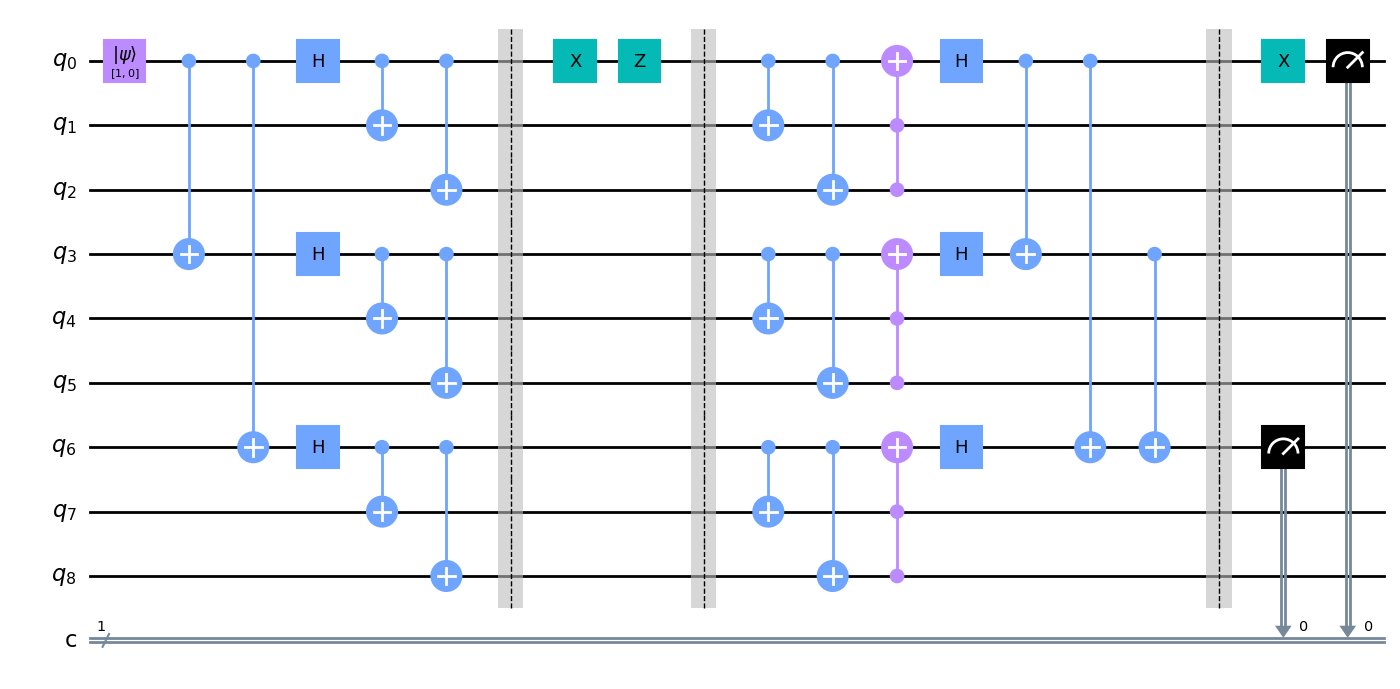

In [72]:
circuit.measure([0],[0])


circuit.draw('mpl')

In [73]:
counts = Simulators.QasmSimulator(circuit, 1024)

In [75]:
print(counts) 

{'0': 1024}


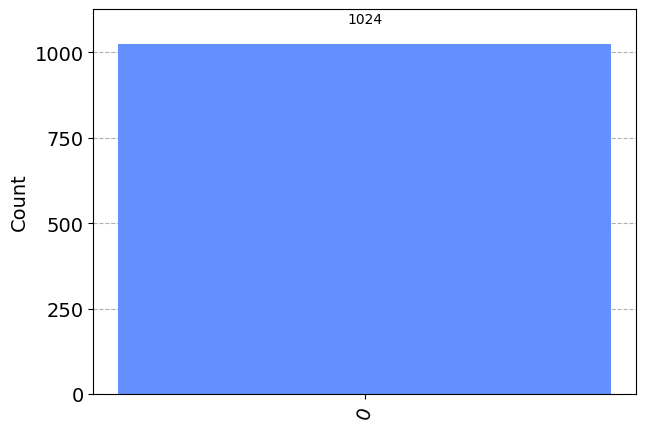

In [76]:
plot_histogram(counts) # The qubit is flipped back to 0 as initialized 

## Testing on real Hardware

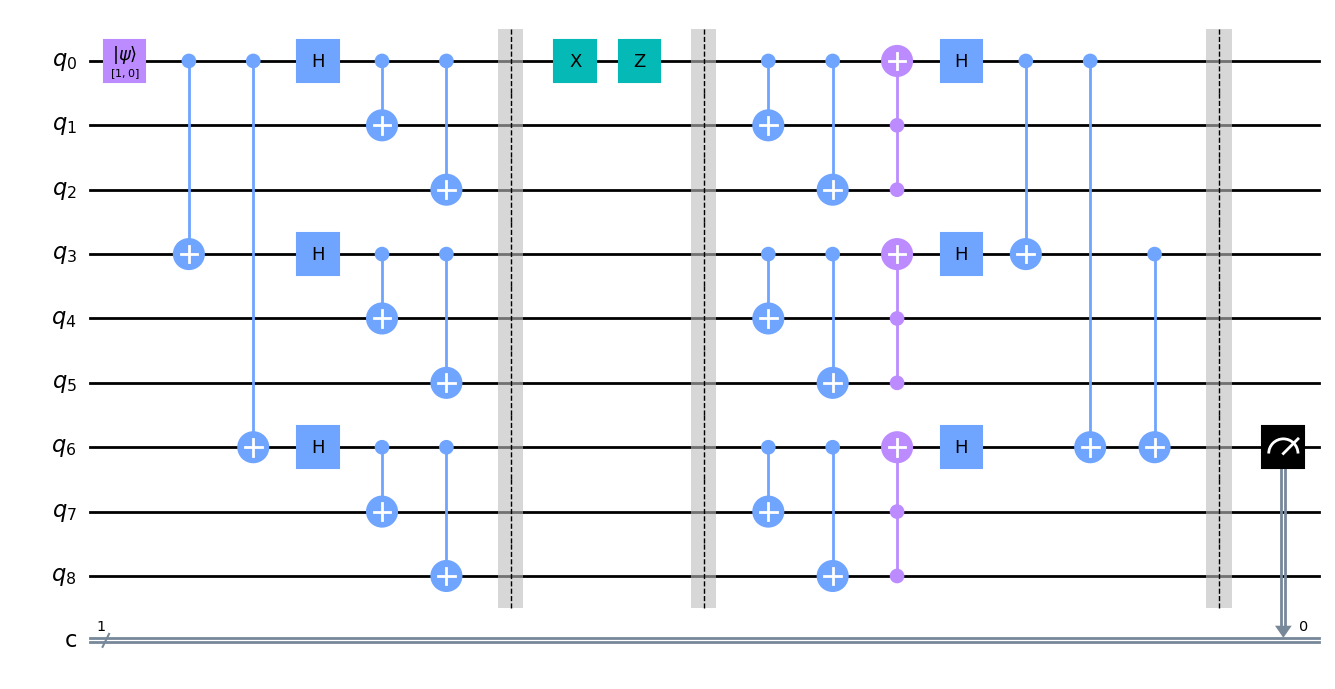

In [77]:
circuit2 = QuantumCircuit(9,1)
circuit2.append(ini_gate,[0])
circuit2.cx(0,3)
circuit2.cx(0,6)
circuit2.h([0,3,6])
circuit2.cx(0,1)
circuit2.cx(0,2)
circuit2.cx(3,4)
circuit2.cx(3,5)
circuit2.cx(6,7)
circuit2.cx(6,8)
circuit2.barrier()

circuit2.x(0)
circuit2.z(0)

circuit2.barrier()
circuit2.cx(0,1)
circuit2.cx(0,2)
circuit2.cx(3,4)
circuit2.cx(3,5)
circuit2.cx(6,7)
circuit2.cx(6,8)
circuit2.ccx(1,2,0)
circuit2.ccx(4,5,3)
circuit2.ccx(8,7,6)
circuit2.h([0,3,6])
circuit2.cx(0,3)
circuit2.cx(0,6)
circuit2.cx(3,6)
circuit2.barrier()
circuit2.measure([6],[0])
circuit2.draw(output='mpl')


In [78]:
quantum_9_qubit = QuantumComputer('ibm_osaka', circuit2, 1024)

In [79]:
quantum_9_job_monitor , quantum_9_job = quantum_9_qubit.RealQuantumComputer()

ibmqfactory.load_account:WARNING:2023-12-07 05:50:13,969: Credentials are already in use. The existing account in the session will be replaced.


cnrnt891wgj00080hb7g
Job Status: job has successfully run


In [80]:
job_9_result = quantum_9_job.result()

The outcome of the syndrome is similar to that of the actual shors code in a real hardware

from the syndrome counts the majority of the qubit state is zero as the 1 represents the 0 occurance as 
I entangled qubit 6 with qubit 3

In [110]:
# The outcome measurement of a real hardware is totally different from that of the simulator which shows that 
# a simple circuit cannot completely reduce the error on a single qubit

In [81]:
job_9_counts = job_9_result.get_counts(circuit2)
print(job_9_counts)

{'1': 523, '0': 501}


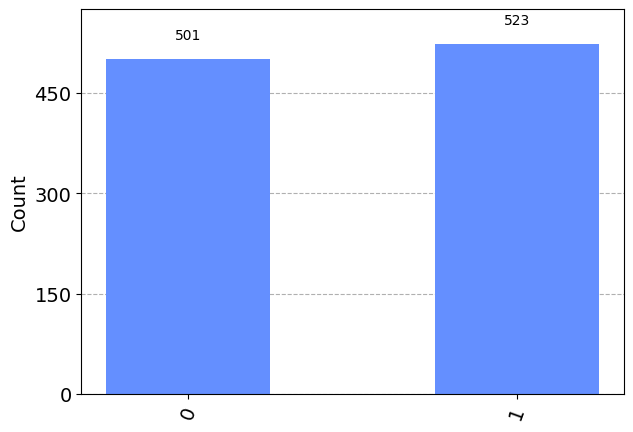

In [82]:
plot_histogram(job_9_counts)

In [111]:
# Failed to proceed further with the custom circuit I created as the outcome shows majority as 0 like I initialized before. 

In [112]:
# Even without toffled gate we can simulate a simple shors code on a normal Quantum circuit with syndrome measurement
# but will fail in the actual quantum hardware for error correction